###CS156 Assignment 4: MNIST Digits
_Yoav Rabinovich, Oct 2018_

-------------------------

For this assignment, the instructions were vauge on whether we should train a classifier for two digits, or plot the two digits and do multiclass classification for the rest of the assignment. I chose the latter (albeit less likely), so that I can get an opportunity to talk about multiclass classification. This has vastly (see below) lengthened training times, so I trained on 50% of the dataset by sampling randomly from the original.

__Multiclass Classification by solving multiple binary classification problems__

Multiclass classification is usually handeled by creating several binary classifiers and aggragating their results. The two prevalent methods are called "One vs One" and "One vs Rest". Other strategies and other methods that are used today, but I focus on the most popular.

__One vs One__

In OvO multiclass classification, a classifier is built for every pair in the output space, classifying, for out purposes, every number into either a 1 or a 2, then into either a 1 or a 3 and so on.  This results in building $\frac{K(K-1)}{2}$ separate classifiers, where $K$ is the size of the output space, each trained on the relevant samples from the training data. When a test sample is introduced, each classifier casts a vote and the class most voted for is picked. In our case, hopefully all 9 classifiers associated with the digit 1 vote for 1 when a test 1 is seen, where no other number will get similar success. The classifiers associated with 7 might all vote 7, save the 7-1 classifier, which would turn the tide. If it doesn't, OvO classification can run into ties, usually broken randomly.

__One vs Rest__

In OvR multiclass classification, only $K$ classifiers are needed, one per output class. Each classifier is trained on the entire dataset, relabling all classes but one as "rest", and distinguishing the chosen class from any of them. While this drastically lowers the number of classifiers, voting is clearly not a strong enough decision function for the problem with only $K$ voters. For this reason, OvR emplys classifiers that output a confidence level, and chooses the class who's classifier outputs the strongest confidence for a given test sample. For a 1 sample, we would hoe the 1 classifier outputs for example a confidence of 0.97, while the 7 classifier would output 0.84. However, the classifiers are trained with a large number of negative samples by design, which would lead to a hard bias for negative classification. Additionally, the hidden assumption that all classifiers would behave similarly with regards to variance ad mean in output confidence levels, that might not be the case, and a strong classification for 7, say 0.9, might actually correspond to a lower number for the 1 classifier, say 0.8, leading to a bias towards high-variance classifiers in the final decision.

SKLearn's SVC method uses One vs One for multiclass classification. This meant that for all 63 fits computed in my grid search over kernels, kernel parameters and error penalty parameters, $\frac{10(9)}{2}=45$ classifiers were trained, resulting in  2,835 fits overall. For this reason I used only 50% of the dataset for training, as described above, and still the training took 2 hours. My computer crashed while I was working, and so the final part reporting times and error is done with information from a previous run with 25,000 samples.

In [0]:
# Imports
from sklearn.datasets import fetch_mldata
from shutil import copyfileobj
from six.moves import urllib
from sklearn.datasets.base import get_data_home
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
# Import dataset (From Slack)

def fetch_mnist(data_home=None):
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    data_home = get_data_home(data_home=data_home)
    data_home = os.path.join(data_home, 'mldata')
    if not os.path.exists(data_home):
        os.makedirs(data_home)
    mnist_save_path = os.path.join(data_home, "mnist-original.mat")
    if not os.path.exists(mnist_save_path):
        mnist_url = urllib.request.urlopen(mnist_alternative_url)
        with open(mnist_save_path, "wb") as matlab_file:
            copyfileobj(mnist_url, matlab_file)

fetch_mnist()
mnist = fetch_mldata("MNIST original")

In [0]:
# Convert to Pandas Dataframe
digits = pd.DataFrame(index=range(len(mnist["data"])),columns=["data","label"])
digits["data"] = pd.Series(list(mnist["data"]))
digits["label"]=pd.Series(mnist["target"])
# Take randomized subset to optimize training time
size = 35000
digits = digits.sample(size)
digits = digits.reset_index(drop=True)

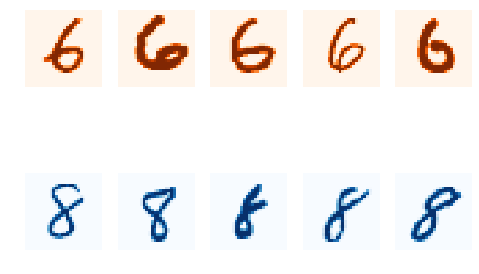

In [0]:
# Plotting sample pictures of my favorite digits

# Collect examples
sixs = []
# Confuse your enemies
nines = []
for i in range(len(digits["data"])):
  if (digits["label"][i]==6) and (len(sixs)<6):
    pixels = digits["data"][i].reshape((28, 28))
    sixs.append(pixels)
  if (digits["label"][i]==8) and (len(nines)<6):
    pixels = digits["data"][i].reshape((28, 28))
    nines.append(pixels)
  if len(sixs)+len(nines)==11:
    break
    
# Plot examples, but not as if they're written in chalk because that's boring
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow(sixs[i],cmap="Oranges")
  plt.axis('off')
  plt.subplot(2,5,i+6)
  plt.imshow(nines[i],cmap="Blues")
  plt.axis('off')


In [0]:
# SVM Kernel Comparison

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(np.vstack(digits["data"]), digits["label"], test_size=0.2)

# Gridsearch over kernel, C, degree and gamma
param_grids = [
    {'kernel': ['linear'], 'C': [1, 10, 100]},
    {'kernel': ['poly'], 'C': [1, 10, 100], 'degree': [2,3,4]},
    {'kernel': ['rbf'], 'C': [1, 10, 100],'gamma': [10**-9,10**-8,10**-7]}
]
search = GridSearchCV(SVC(), param_grids, cv=3, n_jobs=-1, verbose=49, iid=True, return_train_score = False) # Setting some parameters to their default values to avoid some deprecation warnings
search.fit(X_train, y_train)
# Print best estimator parameters
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

[CV]  C=1, gamma=1e-08, kernel=rbf, score=0.9183542269366763, total= 6.7min
[CV] C=1, gamma=1e-08, kernel=rbf ....................................


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed: 74.8min


[CV]  C=1, gamma=1e-09, kernel=rbf, score=0.8543564462544208, total=15.0min
[CV] C=1, gamma=1e-07, kernel=rbf ....................................


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed: 74.9min


[CV]  C=1, gamma=1e-07, kernel=rbf, score=0.9581191088260497, total= 3.5min
[CV] C=1, gamma=1e-07, kernel=rbf ....................................


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 78.5min


[CV]  C=1, gamma=1e-08, kernel=rbf, score=0.9138356017575823, total= 6.6min
[CV] C=1, gamma=1e-07, kernel=rbf ....................................


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed: 81.5min


[CV]  C=1, gamma=1e-07, kernel=rbf, score=0.9553198328511733, total= 3.5min
[CV] C=10, gamma=1e-09, kernel=rbf ...................................


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed: 81.9min


[CV]  C=1, gamma=1e-07, kernel=rbf, score=0.9545600685885757, total= 3.6min
[CV] C=10, gamma=1e-09, kernel=rbf ...................................


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 85.1min


[CV]  C=10, gamma=1e-09, kernel=rbf, score=0.918808911739503, total= 6.4min
[CV] C=10, gamma=1e-09, kernel=rbf ...................................


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 88.4min


[CV]  C=10, gamma=1e-09, kernel=rbf, score=0.9172827600985749, total= 6.6min
[CV] C=10, gamma=1e-08, kernel=rbf ...................................


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed: 91.7min


[CV]  C=10, gamma=1e-09, kernel=rbf, score=0.9121208873646983, total= 6.3min
[CV] C=10, gamma=1e-08, kernel=rbf ...................................


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 94.7min


[CV]  C=10, gamma=1e-08, kernel=rbf, score=0.9405526992287918, total= 3.4min
[CV] C=10, gamma=1e-08, kernel=rbf ...................................


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed: 95.0min


[CV]  C=10, gamma=1e-08, kernel=rbf, score=0.9364620165005894, total= 3.2min
[CV] C=10, gamma=1e-07, kernel=rbf ...................................


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 97.9min


[CV]  C=10, gamma=1e-08, kernel=rbf, score=0.9373057550101811, total= 3.4min
[CV] C=10, gamma=1e-07, kernel=rbf ...................................


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed: 98.4min


[CV]  C=10, gamma=1e-07, kernel=rbf, score=0.9686161096829478, total= 2.8min
[CV] C=10, gamma=1e-07, kernel=rbf ...................................


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed: 100.7min


[CV]  C=10, gamma=1e-07, kernel=rbf, score=0.9683917282760098, total= 2.9min
[CV] C=100, gamma=1e-09, kernel=rbf ..................................


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 101.3min


[CV]  C=10, gamma=1e-07, kernel=rbf, score=0.969456649876755, total= 2.7min
[CV] C=100, gamma=1e-09, kernel=rbf ..................................


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed: 103.4min


[CV]  C=100, gamma=1e-09, kernel=rbf, score=0.9355184233076264, total= 3.4min
[CV] C=100, gamma=1e-09, kernel=rbf ..................................


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed: 104.6min


[CV]  C=100, gamma=1e-09, kernel=rbf, score=0.9334619093539055, total= 3.2min
[CV] C=100, gamma=1e-08, kernel=rbf ..................................


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 106.7min


[CV]  C=100, gamma=1e-09, kernel=rbf, score=0.9326974600793055, total= 3.3min
[CV] C=100, gamma=1e-08, kernel=rbf ..................................


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 107.9min


[CV]  C=100, gamma=1e-08, kernel=rbf, score=0.9484790059982862, total= 2.5min
[CV] C=100, gamma=1e-08, kernel=rbf ..................................


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed: 109.1min


[CV]  C=100, gamma=1e-08, kernel=rbf, score=0.9457837779920711, total= 2.5min
[CV] C=100, gamma=1e-07, kernel=rbf ..................................


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed: 110.5min


[CV]  C=100, gamma=1e-08, kernel=rbf, score=0.9456649876754903, total= 2.4min
[CV] C=100, gamma=1e-07, kernel=rbf ..................................


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed: 111.6min


[CV]  C=100, gamma=1e-07, kernel=rbf, score=0.9701156812339332, total= 2.8min
[CV] C=100, gamma=1e-07, kernel=rbf ..................................
[CV]  C=100, gamma=1e-07, kernel=rbf, score=0.9692489017464909, total= 2.8min
[CV]  C=100, gamma=1e-07, kernel=rbf, score=0.9703140070731968, total= 2.7min


[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed: 116.0min finished


Best parameter (CV score=0.970):
{'C': 100, 'gamma': 1e-07, 'kernel': 'rbf'}


In [0]:
# Print classification report for best estimator
print(classification_report(y_test,search.best_estimator_.predict(X_test)))
print(confusion_matrix(y_test,search.best_estimator_.predict(X_test)))

             precision    recall  f1-score   support

        0.0       0.98      0.98      0.98       675
        1.0       0.99      1.00      0.99       815
        2.0       0.95      0.98      0.97       683
        3.0       0.96      0.96      0.96       740
        4.0       0.97      0.98      0.97       654
        5.0       0.97      0.97      0.97       634
        6.0       0.98      0.99      0.99       684
        7.0       0.98      0.97      0.98       744
        8.0       0.98      0.96      0.97       636
        9.0       0.97      0.96      0.97       735

avg / total       0.97      0.97      0.97      7000

[[663   1   5   1   1   1   1   0   2   0]
 [  1 811   0   1   0   0   0   1   0   1]
 [  1   0 668   4   3   2   0   3   2   0]
 [  1   1  10 708   0   9   0   5   3   3]
 [  0   1   4   0 638   0   2   0   0   9]
 [  1   0   4   8   0 613   4   1   1   2]
 [  4   0   0   0   1   1 678   0   0   0]
 [  1   2   6   0   7   0   0 723   1   4]
 [  2   3   4   6

In [0]:
# Collect result data
results = pd.DataFrame(search.cv_results_)


# Report average training times for each kernel
lin_times=[]
pol_times=[]
rbf_times=[]
best_times=[0,0,0]
best_est=[None,None,None]
for row in results.iterrows():
  if row[1][5]=='linear':
    lin_times.append(row[1][0])
    if row[1][12]>best_times[0]:
      best_times[0] = row[1][12]
      best_est[0]=row[1][8]
  if row[1][5]=='poly':
    pol_times.append(row[1][0])
    if row[1][12]>best_times[1]:
      best_times[1] = row[1][12]
      best_est[1]=row[1][8]
  if row[1][5]=='rbf':
    rbf_times.append(row[1][0])
    if row[1][12]>best_times[2]:
      best_times[2] = row[1][12]
      best_est[2]=row[1][8]
    
print("Mean Training Times:")
print("Linear Kernel: " + str(sum(lin_times)/len(lin_times)) + " seconds.")
print("Polynomial Kernel: " + str(sum(pol_times)/len(pol_times)) + " seconds.")
print("Radial Basis Function Kernel: " + str(sum(rbf_times)/len(rbf_times)) + " seconds.")

# Report error on test set with classification report, for best estimator of each kernel
lin_est=SVC(kernel='linear',C=best_est[0]["C"]).fit(X_train,y_train)
lin_pred=lin_est.predict(X_test)
pol_est=SVC(kernel='poly',C=best_est[1]["C"],degree=best_est[1]["degree"]).fit(X_train,y_train)
pol_pred=lin_est.predict(X_test)
rbf_est=SVC(kernel='rbf',C=best_est[2]["C"],gamma=best_est[2]["gamma"]).fit(X_train,y_train)
rbf_pred=lin_est.predict(X_test)

print("Classification Reports:")
print("Linear Kernel:")
print(classification_report(y_test,lin_pred))
print("Polynomial Kernel:")
print(classification_report(y_test,pol_pred))
print("Radial Basis Function Kernel:")
print(classification_report(y_test,rbf_pred))

Mean Training Times:
Linear Kernel: 63.99365679423014 seconds.
Polynomial Kernel: 82.97143636809454 seconds.
Radial Basis Function Kernel: 155.04097125265332 seconds.


C:\Users\rabin\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Classification Reports:
Linear Kernel:
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94       497
         1.0       0.95      0.98      0.96       519
         2.0       0.86      0.90      0.88       470
         3.0       0.85      0.88      0.87       523
         4.0       0.90      0.95      0.92       498
         5.0       0.86      0.88      0.87       445
         6.0       0.95      0.93      0.94       478
         7.0       0.93      0.92      0.92       558
         8.0       0.92      0.81      0.86       478
         9.0       0.91      0.84      0.87       534

   micro avg       0.91      0.91      0.91      5000
   macro avg       0.91      0.90      0.90      5000
weighted avg       0.91      0.91      0.91      5000

Polynomial Kernel:
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94       497
         1.0       0.95      0.98      0.96       519
         2.0       0

{'C': 100, 'gamma': 1e-07, 'kernel': 'rbf'}